# BastionLab Authentication Tutorial

In this tutorial, we are going to start the `BastionLab server` with user authentication enabled and then connect the `client` to it.

Thereafter, we will execute simple queries on a Remote DataFrame (RDF), as used in the [Quick Tour of BastionLab](../quick-tour/quick-tour.ipynb). 

As an addition, we will proof that the authentication works by creating connecting to the server with an unknown identity.

## Installing BastionLab Client from PyPi

In [ ]:
! pip install polars bastionlab

# Installing BastionLab Server

### Using the official docker image

In [ ]:
!docker pull mithrilsecuritysas/bastionlab:latest

## Setting up the keys

In an authentication-enabled environment, BastionLab only accept request from verified users (i.e., _users known whose public keys are known to the server at start-up_). 

Authentication is done with asymmetric cryptography: 
- the data owners provides a list of authorized public keys to the server upon start-up;
- all users must provide their corresponding private key to the client when they connect to the server. 
  
The client then transparently creates a session for the user which is refreshed, by default, every _25 minutes_.

BastionLab provides a utility module to manage the keys. We will use it to create the public and private keys for a single user.

The `Identity` class on the `client` is used to create a key-pair (public and private keys).

### Identity creation

In this sub-section, we will create two identities: 
- one for the data owner;
- one for the data scientist;

> NB: The keys generated from the identity creation are placed in the current working directory.

In [8]:
from bastionlab import Identity

# Create `Identity` for Data owner.
data_owner = Identity.create("data_owner")

# Create `Identity` for Data Scientist.
data_scientist = Identity.create("data_scientist")

Now that we have setup our identities, we will have to start the server with both the **public key** of the data owner and the data scientist.

> Please note that this step will have to be done by the party setting up the server, commonly the **data owner**. They will have to get all the public keys of the interested parties.

### BastionLab Server Public Keys Structure.

Illustrated below is the directory structure of **BastionLab server**.

```sh
keys/
├─ owners/
├─ users/
```

> By convention, `keys` is used as the root directory name.

For ease of use, it's best to have have a directory structre for your public keys similar to that of BastionLab server.

In order to do that, run the following commands to create `keys/owners` and `keys/users` in your current working directory.

In [3]:
!mkdir -p keys/owners keys/users

For the purpose of this tutorial, we copy both the public keys of the data owner and data scientist.

In [4]:
!cp data_owner.pub $(pwd)/keys/owners
!cp data_scientist.pub $(pwd)/keys/users

# Starting BastionLab Server with Public Keys.

In [ ]:
!docker run -it -p 50056:50056 -v $(pwd)/keys:/app/bin/keys mithrilsecuritysas/bastionlab:latest

## Setting up an Authenticated Connection

This tutorial is essentially the same as [Quick Tour](../quick-tour/quick-tour.ipynb) but using an **authenticated** connection.

> NB: Please remember that we use `data_owner` from [Identity Creation](#identity-creation)

In [5]:
!wget 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'

--2022-12-07 13:06:44--  https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  58.89K  --.-KB/s    in 0.007s  

2022-12-07 13:06:45 (8.57 MB/s) - ‘titanic.csv’ saved [60302/60302]



# Data Owner's Side

In this Tour, we assume the Data Owner has a private dataset they want to explore. As they don't have the expertise, they would like to hire a Data Scientist and to give them a restricted access to their private data.

To keep this Tour short and simple, we will use weak but reasonable guarantees. If you're interested in setting up stricter policies, you are encouraged to have a look at our [Privacy policy tutorial](docs/).

BastionLab already ensures that the original dataset cannot be downloaded by the Data Scientist. In addition to that, we will set up a policy that logs all non privacy-preserving request so that the Data Owner can take adequate actions.

This section is devided in three steps:
- load the dataset
- establish a connection
- send the data and set a custom policy

### Upload the data frame to the BastionLab Client

We first load the dataset we downloaded at the beginning of the Tour in memory as a DataFrame object:

In [9]:
import polars as pl

df = pl.read_csv("titanic.csv")

We then open an authenticated connection to the server by providing its hostname.

In [10]:
from bastionlab import Connection

connection = Connection("localhost", identity=data_owner)

Using BastionLab client, we can upload our data to the server in a secure and private fashion. To protect our data, we also define a custom privacy Policy.

A policy defines a `safe_zone` which is a condition any request must meet to be considered privacy-preserving. It also defines an `unsafe_handling` which is the action taken in case a request violates the `safs_zone`.

For the purpose of this Tour, we'll use the following:
- we consider any request that aggregates at least 10 rows of the original DataFrame safe,
- we log any offending request on the server side for the Data Owner to see it.

To send the DataFrame, we use the `send_df()` method of the `polars` interface of the client. We pass our custom policy and a list of columns to be sanitized (i.e. set to null) if retrieved by the Data Scientist.

In [11]:
from bastionlab.polars.policy import Policy, Aggregation, Log

policy = Policy(safe_zone=Aggregation(min_agg_size=10), unsafe_handling=Log())
connection.client.polars.send_df(df, policy=policy, sanitized_columns=["Name"])

FetchableLazyFrame(identifier=5437d8ca-69f4-4ea0-bf47-bafa5fd725e3)

The server returns a FetchableLazyFrame which essentially is a reference to the remote DataFrame that can be use as if it were locally available. We'll see how to use it in the Data Scientist's side section.

# Data Scientist's Side

In [12]:
connection = Connection("localhost", identity=data_scientist)

client = connection.client

all_rdfs = client.polars.list_dfs()

rdf = all_rdfs[0]

all_rdfs

[FetchableLazyFrame(identifier=5437d8ca-69f4-4ea0-bf47-bafa5fd725e3)]

### Running Queries

Now that we have a `RemoteLazyFrame` corresponding to the data owner’s DataFrame, it is time to run some queries on it.

To define these queries, we can directly use all the methods provided by polars’ lazy API. Here, the adjective lazy means that no computation will be run unless explicitly needed. This allows the data scientist to build queries with a Pythonic approach from the RemoteLazyFrame, and when an operation needs to be executed on the data, the query is serialized and sent to the server. 

The `collect()` method triggers the execution of all the recorded operations on the server.


In [13]:
rdf1 = rdf.head(5)
print(rdf1)

rdf2 = rdf1.collect()
print(rdf2)

RemoteLazyFrame
FetchableLazyFrame(identifier=348cb17d-0912-467a-aa61-b6aa63caf316)


In this example, the first line returns a new RemoteLazyFrame that records the head operation - nothing happens on the server. In the second line, however, the call to collect()  sends a query to the server instructing it to do a head operation, and will run it right away.


What is key to understanding, is that **every call to collect() will create a new DataFame** on the server side that contains the result.

On the client side, **collect() returns a new FetchableLazyFrame** that references the result on the server.

### Fetching Results

At some point in your process, you will need to download the results to use them locally or to display them. This can be achieved with the fetch method.

The fetch method is defined on the FetchableLazyFrame class which extends the RemoteLazyFrame class. 

Recall that we’ve already seen the two ways of getting FetchableLazyFrames: by listing available DataFrames on the server, and by calling collect() on any RemoteLazyFrame. 
In practice, this means that fetch() may only be called on references to DataFrames already available on the server or after a call to collect(). As no computation has run before you call collect(), it wouldn’t actually make sense to fetch() the result because it does not yet exist! 


In [14]:
rdf.head(5).collect().fetch()

Reason: Only 1 subrules matched but at least 2 are required.
Failed sub rules are:
Rule #1: Cannot fetch a DataFrame that does not aggregate at least 10 rows of the initial dataframe uploaded by the data owner.

This incident will be reported to the data owner.


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
i64,i64,i64,str,str,f64,i64,i64,str,f64,str,str
1,0,3,null,"""male""",22.0,1,0,"""A/5 21171""",7.25,null,"""S"""
2,1,1,null,"""female""",38.0,1,0,"""PC 17599""",71.2833,"""C85""","""C"""
3,1,3,null,"""female""",26.0,0,0,"""STON/O2. 31012...",7.925,null,"""S"""
4,1,1,null,"""female""",35.0,1,0,"""113803""",53.1,"""C123""","""S"""
5,0,3,null,"""male""",35.0,0,0,"""373450""",8.05,null,"""S"""


In addition, `fetch()` downloads the resulting DataFrame after performing some checks on how it was obtained and what the data owner authorizes in their policy. These checks allow BastionLab to uphold a decent level of privacy without too big an impact on your workflow.

Recall that the Data Owner has set the following policy:
- a `safe_zone` that accepts queries aggregating at least 10 original rows,
- the `Log` `unsafe_hanling` action which prints a message in the server logs in case of a violation of the `safe_zone`.

As printing the first rows of a DataFrame is not an aggregation, we are actually violating the safe zone which explains the printed warning message. The same message is also recorded in the logs of the server.

Also note that the *Name* column has been filled with `null` values as it was added to the `sanitized_columns` list by the Data Owner.


In [15]:
per_class_rates = (
    rdf.select([pl.col("Pclass"), pl.col("Survived")])
    .groupby(pl.col("Pclass"))
    .agg(pl.col("Survived").mean())
    .sort("Survived", reverse=True)
    .collect()
    .fetch()
)
per_class_rates

Pclass,Survived
i64,f64
1,0.62963
2,0.472826
3,0.242363


#### Barplot

Barplots inherently aggregate data which makes them a good fit por private data exploration.
Instead of fetching the whole DataFrame, BastionLab client selects relevant rows, runs an aggregation query on the server and fetches the aggregated data.

In the following example, we plot the number of passengers who survived per age class. We set a bin size of 10 which means our age classes span 10 years.

Reason: Only 1 subrules matched but at least 2 are required.
Failed sub rules are:
Rule #1: Cannot fetch a DataFrame that does not aggregate at least 10 rows of the initial dataframe uploaded by the data owner.

This incident will be reported to the data owner.


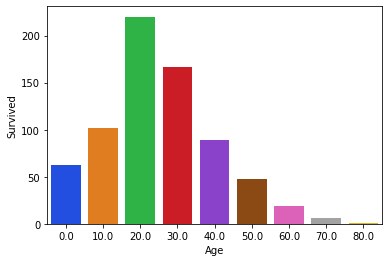

In [16]:
rdf.histplot(col_x="Age", col_y="Survived", bins=10, palette="bright")

We get a warning message because there are outliers in our data: people aged 70 or more are few and form groups that are smaller than 10 in size violating the Data Owner's policy.
It turns out it is actually easier to deanonymize outlier data as correlation can be made more easily.

One solution to make our example more-privacy preserving is to clip the age column to remove outliers prior to making the barplot.

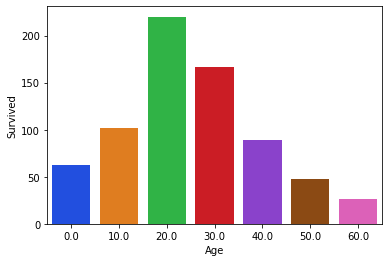

In [17]:
rdf.select([pl.col("Survived"), pl.col("Age").clip(0, 60)]).histplot(
    col_x="Age", col_y="Survived", bins=10, palette="bright"
)

In this case, outliers are counted in a new 60+ bin, and each bin aggregates at least 10 passengers. The query does not violate the safe zone anymore.

#### Curve and scatter plots

BastionLab also features other types of plots although these are less suited for privacy-preserving exploration.
They typically require fetching the whole DataFrame as they do not naturally involve an aggregation step as barplots do.

Bellow are two examples of the same relationship between age and survival as a curve plot and as a scatter plot.

Reason: Only 1 subrules matched but at least 2 are required.
Failed sub rules are:
Rule #1: Cannot fetch a DataFrame that does not aggregate at least 10 rows of the initial dataframe uploaded by the data owner.

This incident will be reported to the data owner.


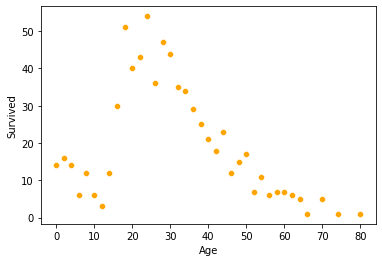

In [18]:
rdf.scatterplot(col_x="Age", col_y="Survived", bins=2, color="orange")

Reason: Only 1 subrules matched but at least 2 are required.
Failed sub rules are:
Rule #1: Cannot fetch a DataFrame that does not aggregate at least 10 rows of the initial dataframe uploaded by the data owner.

This incident will be reported to the data owner.


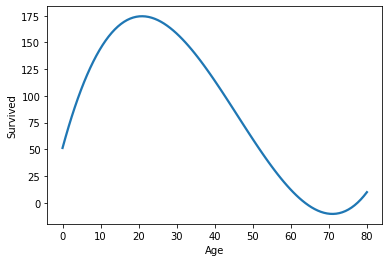

In [19]:
rdf.curveplot(col_x="Age", col_y="Survived", bins=10)

For more information on these functions and more complex examples, check out our data visualization tutorial [here](../tutorials/visualization.ipynb).

Let’s now try a more involved query: we compute the survival rates of the passengers on the Titanic based on their ticket class.